<a id='0'></a>
### 0️⃣ Initialize notebook variables

In [ ]:
import os, sys, json
sys.path.insert(1, '../../shared')  # add the shared directory to the Python path
import utils

deployment_name = "ai-gw-demo"
resource_group_name = f"rg-aigw-demo-gab-turin-25-it-1" # change the name to match your naming style
resource_group_location = "italynorth" # change the location to match your naming style

apim_sku = 'Developer'

openai_resources = [ {"name": "openai1", "location": "italynorth"}]


openai_model_name = "gpt-4o-mini"
openai_model_version = "2024-07-18"
openai_model_sku = "GlobalStandard"
openai_model_capacity = 8
openai_deployment_name = "gpt-4o-mini"
openai_api_version = "2024-10-21"

utils.print_ok('Notebook initialized')

✅ Notebook initialized ⌚ 19:57:03.590657 


<a id='1'></a>
### 1️⃣ Verify the Azure CLI and the connected Azure subscription

In [2]:
output = utils.run("az account show", "Retrieved az account", "Failed to get the current az account")

if output.success and output.json_data:
    current_user = output.json_data['user']['name']
    tenant_id = output.json_data['tenantId']
    subscription_id = output.json_data['id']

    utils.print_info(f"Current user: {current_user}")
    utils.print_info(f"Tenant ID: {tenant_id}")
    utils.print_info(f"Subscription ID: {subscription_id}")

⚙️ Running: az account show 
✅ Retrieved az account ⌚ 19:57:10.254485 :1s]
👉🏽 Current user: fcannas@welol.it
👉🏽 Tenant ID: 88c43b68-eaa3-465e-b5b4-d1b1d7f611b2
👉🏽 Subscription ID: b974ef5d-8851-4145-a7d8-35c12152ad97


<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

In [14]:
# Create the resource group if doesn't exist
utils.create_resource_group(resource_group_name, resource_group_location)

# Define the Bicep parameters
bicep_parameters = {
    "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
    "contentVersion": "1.0.0.0",
    "parameters": {
        "apimSku": { "value": apim_sku },
        "openAIConfig": { "value": openai_resources },
        "openAIDeploymentName": { "value": openai_deployment_name },
        "openAIModelName": { "value": openai_model_name },
        "openAIModelSKU": { "value": openai_model_sku },
        "openAIModelCapacity": { "value": openai_model_capacity },
        "openAIModelVersion": { "value": openai_model_version },
        "openAIAPIVersion": { "value": openai_api_version }
    }
}

# Write the parameters to the params.json file
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

# Run the deployment
output = utils.run(f"az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file main.bicep --parameters params.json",
    f"Deployment '{deployment_name}' succeeded", f"Deployment '{deployment_name}' failed")

⚙️ Running: az group show --name lab-cannasdev 
👉🏽 Using existing resource group 'lab-cannasdev'
⚙️ Running: az deployment group create --name token-rate-limiting --resource-group lab-cannasdev --template-file main.bicep --parameters params.json 
✅ Deployment 'token-rate-limiting' succeeded ⌚ 11:14:11.130050 :44s]


<a id='3'></a>
### 3️⃣ Get the deployment outputs

Retrieve the required outputs from the Bicep deployment.

In [3]:
# Obtain all of the outputs from the deployment
output = utils.run(f"az deployment group show --name {deployment_name} -g {resource_group_name}", f"Retrieved deployment: {deployment_name}", f"Failed to retrieve deployment: {deployment_name}")

if output.success and output.json_data:
    apim_service_id = utils.get_deployment_output(output, 'apimServiceId', 'APIM Service Id')
    apim_resource_gateway_url = utils.get_deployment_output(output, 'apimResourceGatewayURL', 'APIM API Gateway URL')
    apim_subscription_key = utils.get_deployment_output(output, 'apimSubscriptionKey', 'APIM Subscription Key (masked)', True)

⚙️ Running: az deployment group show --name token-rate-limiting -g lab-cannasdev 
✅ Retrieved deployment: token-rate-limiting ⌚ 19:57:17.523285 :3s]
👉🏽 APIM Service Id: /subscriptions/b974ef5d-8851-4145-a7d8-35c12152ad97/resourceGroups/lab-cannasdev/providers/Microsoft.ApiManagement/service/apim-obscxbthf7gei
👉🏽 APIM API Gateway URL: https://apim-obscxbthf7gei.azure-api.net
👉🏽 APIM Subscription Key (masked): ****bfdc


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior and troubleshoot the [policy](policy.xml).

In [4]:
import requests

url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []
for i in range(10):
    messages={"messages":[
        {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]}
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    if (response.status_code == 200):
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "✅")
        data = json.loads(response.text)
        total_tokens = data.get("usage").get("total_tokens")
        print("💬 ", data.get("choices")[0].get("message").get("content"))
        print("Full response: ", data)
        print("Total tokens used: ", total_tokens)
    else:
        print("▶️ Run: ", i+1, "status code: ", response.status_code, "⛔")
        print(response.text)
        total_tokens = 0
    api_runs.append((total_tokens, response.status_code))


▶️ Run:  1 status code:  200 ✅
💬  Oh sure, because I totally have a clock built into my digital brain. Maybe just check your phone or look around – I hear there's this thing called a watch that some people still use!
Full response:  {'choices': [{'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}, 'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': "Oh sure, because I totally have a clock built into my digital brain. Maybe just check your phone or look around – I hear there's this thing called a watch that some people still use!", 'refusal': None, 'role': 'assistant'}}], 'created': 1746208651, 'id': 'chatcmpl-BSovbPOuqGkpQuQQDpWWvUK93PdrW', 'model': 'gpt-4o-mini-2024-07-18', 'object': 'chat.completion', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate

<a id='plot'></a>
### 🔍 Analyze Token Rate limiting results


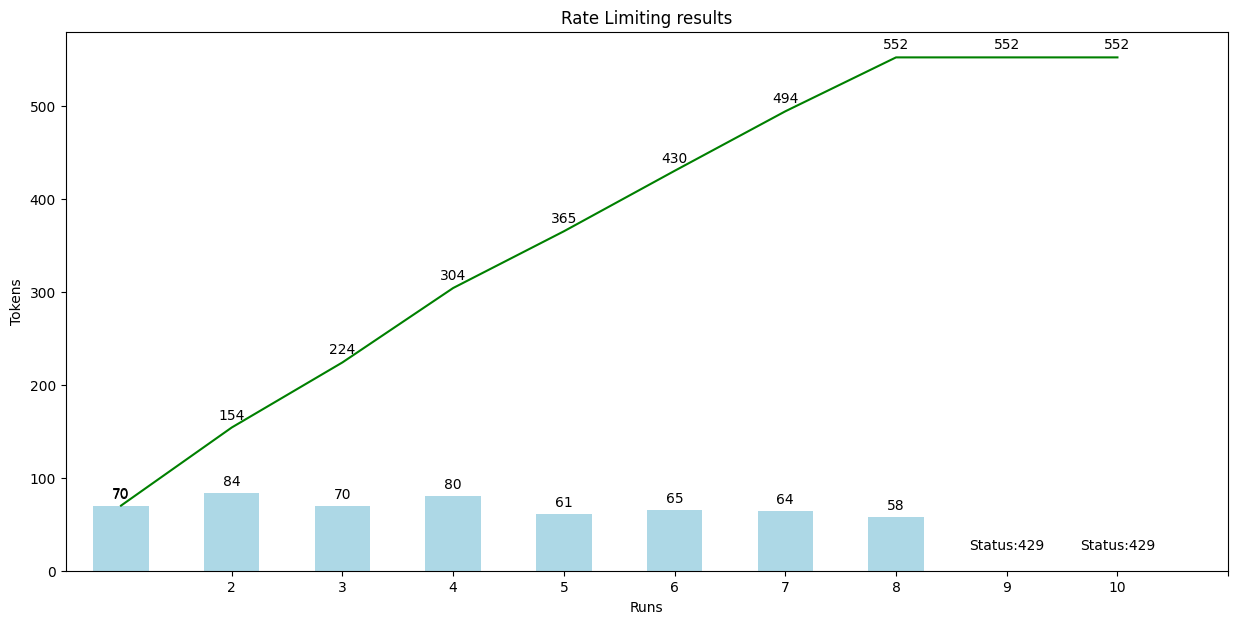

In [5]:
# plot the results
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Tokens', 'Status Code'])
df['Run'] = range(1, len(df) + 1)
colors = ['red' if str(code).startswith('5') else 'yellow' if str(code).startswith('4') else 'lightblue' for code in df['Status Code']]
ax = df.plot(kind='bar', x='Run', y='Tokens', color=colors, legend=False)
plt.title('Rate Limiting results')
plt.xlabel('Runs')
plt.ylabel('Tokens')
plt.xticks(df['Run'], rotation=0)
for i, val in enumerate(df['Status Code']):
    ax.text(i, 20, '' if int(val) == 200 else 'Status:429', ha='center', va='bottom')
for i, val in enumerate(df['Tokens']):
    ax.text(i, df['Tokens'][i] + 5, '' if int(val) == 0 else val, ha='center', va='bottom')
accumulated_tokens = df['Tokens'].cumsum()
ax.plot(df['Run']-1, accumulated_tokens, color='green', label='Accumulated Tokens')
for i, val in enumerate(accumulated_tokens):
    ax.text(i, val + 6, str(int(val)), ha='center', va='bottom', label='Accumulated Tokens')
plt.show()

<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.